## Data Download

In [7]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [8]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


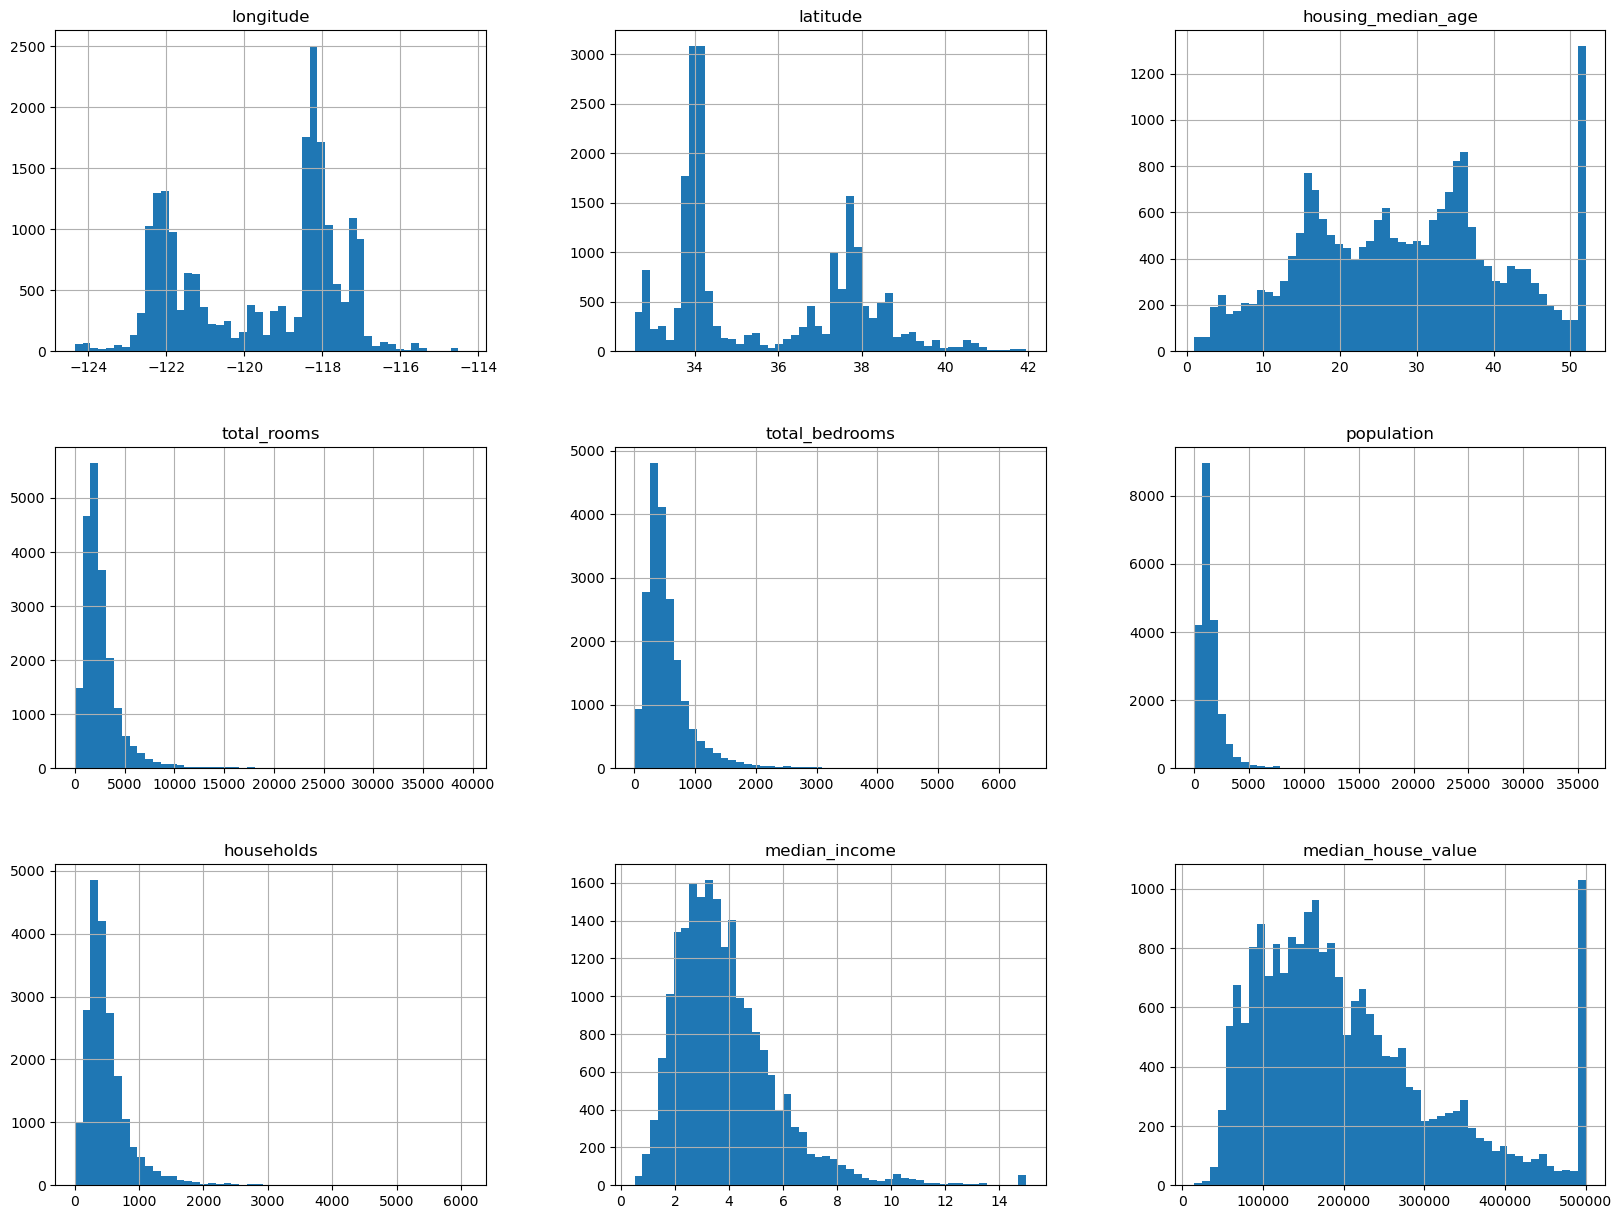

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

## Testset 제작

#### 무작위 샘플링

In [15]:
#index 활용
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    testset_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:testset_size] # 전체 데이터 중 20%는 testset으로
    train_indices = shuffled_indices[testset_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))    

16512 4128


In [16]:
#고유 식별자(위도, 경도) 활용
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [17]:
#scikitlearn 활용
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#### 계층 샘플링

<AxesSubplot:>

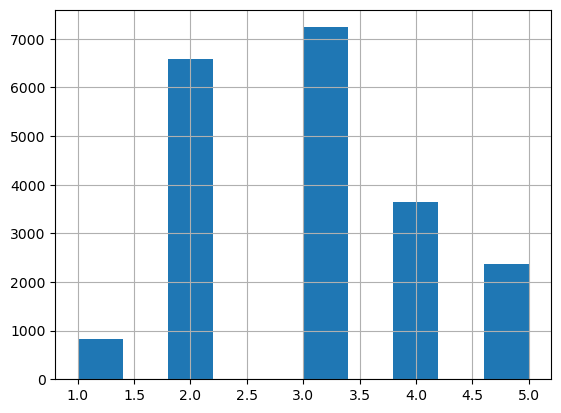

In [18]:
# 중간 소득이 중간 주택 가격을 예측하는 데 매우 중요하다고 가정
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]
    
    print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 데이터 탐색 및 시각화

In [24]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

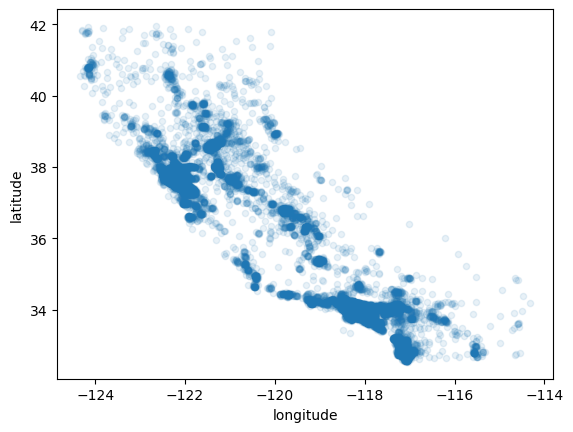

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
# 투명하게끔 설정하여, 밀집된 구역이 진하게 표시되도록 함

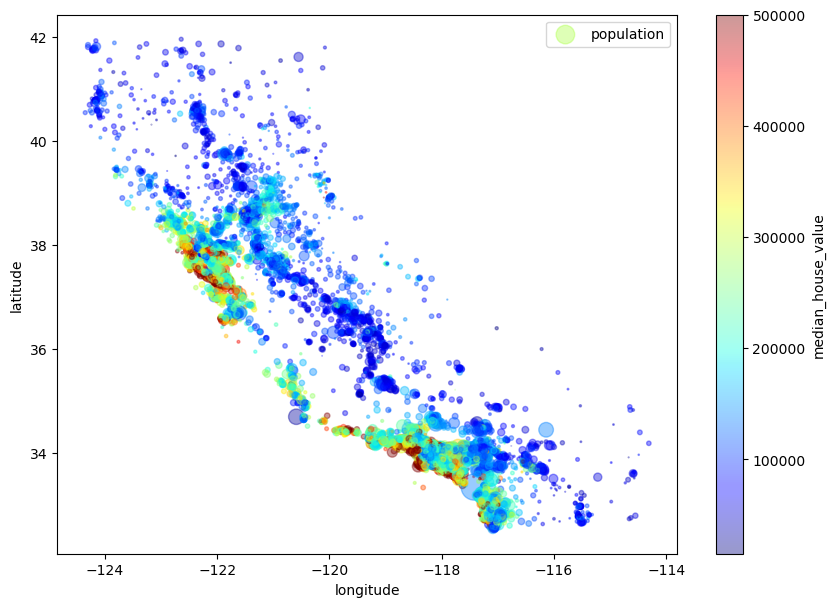

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False
)
plt.legend() # 범례 출력

## Correlation 조사

In [31]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

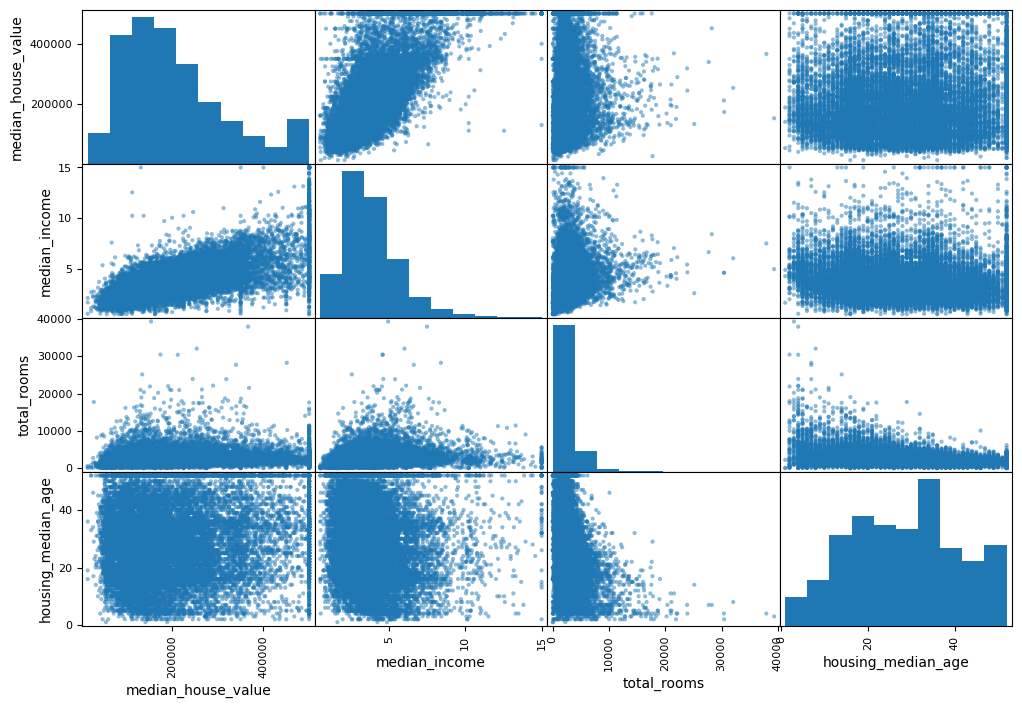

In [32]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value",
              "median_income",
              "total_rooms",
              "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

# 대각선에 위치한 것은 모두 자기 자신에 대한 것이므로 의미 없음

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

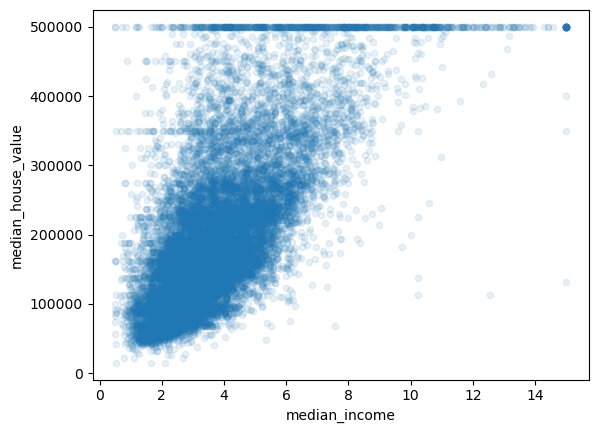

In [33]:
# median_house_value - median_income 상관관계 산점도

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

### 특성 조합

In [36]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"] # 가구당 방 개수
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"] # 가구당 침실 개수
housing["populations_per_household"] = housing["population"] / housing["households"] # 가구당 인원 수

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

#bedrooms_per_room 특성이 나머지 2개의 특성에 비해 medain_house_value와의 상관관계가 훨씬 높은 것을 확인할 수 있음

median_house_value           1.000000
median_income                0.687160
rooms_per_household          0.146285
total_rooms                  0.135097
housing_median_age           0.114110
households                   0.064506
total_bedrooms               0.047689
populations_per_household   -0.021985
population                  -0.026920
bedrooms_per_household      -0.043343
longitude                   -0.047432
latitude                    -0.142724
bedrooms_per_room           -0.259984
Name: median_house_value, dtype: float64

## ML을 위한 Data 준비

In [37]:
# 데이터 복원
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
# 데이터 정제
# 해당 구역 제거 / 전체 특성 삭제 / (0, 평균, 중간값)으로 채움 중 3옵션 선택

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [39]:
# 데이터 정제 - sklearn 이용
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num) # 각 특성의 중간값을 계산하여 해당 결과를 객체의 statistics 속성에 저장

imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [41]:
X = imputer.transform(housing_num) # 변환기 활용
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

#### Text 2 integer

In [42]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [43]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [45]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

#### 나만의 변환기 제작

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, household_ix] / X[:, rooms_ix]
        poulation_per_household = X[:, household_ix] / X[:, population_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, poulation_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, poulation_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#### 변환 파이프라인

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Pipeline은 연속된 단계를 나타내는 이름/추정기 쌍의 목록을 입력으로 받음

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [51]:
# 하나의 변환기로 범주형 열과 수치형 열을 한번에 처리할 수 있음

from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

## Model 선택 및 Training

In [52]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

#### RMSE

In [53]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# 대부분의 중간 주택 가격은 12만 ~ 26.5만 달러 사이 - But 예측 오차는 6.8만 달러이므로 결과가 썩..... <과소적합>

66032.83171817148

#### 의사결정트리로 변경

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [55]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# 오차가 0 ~ <심한 과대적합>

0.0

#### k-fold cross-validation

In [56]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10) # k = 10

tree_rmse_scores = np.sqrt(-scores)
# sklearn의 교차 검증 기능은 scoring param에 클수록 좋은 효용 함수 사용하므로, MSE의 반댓값을 계산하는 함수를 대신 사용

In [59]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

display_scores(tree_rmse_scores)

# 결과를 확인해보면, 선형회귀 모델보다도 결과가 더 좋지 않은 것을 확인할 수 있음

점수: [68272.33204364 67138.64795572 71281.72711591 70165.19553517
 70886.80079278 76148.71120679 71066.97193562 71925.37596265
 76566.815427   71036.04195574]
평균: 71448.8619931002
표준편차: 2819.3135680264695


In [61]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10) # k = 10

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [64583.53227565 64180.59934162 68147.9654757  68404.3574895
 65722.15891982 68873.7440014  64516.28817444 64272.29465366
 69273.70573806 64384.52724393]
평균: 66235.91733137923
표준편차: 2049.477704221182


#### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10) # k = 10

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

# 시간 너무 오래 걸림 - 문제 파악 필요

## Model 세부 튜닝

In [65]:
# Grid 탐색

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [66]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [67]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
# 최적의 모델의 점수 약 4.9만-> 기본 hyperparam 일 때 얻은 50182점보다 좀 더 좋음 -> 최적의 모델 탐색 성공

64934.04196401591 {'max_features': 2, 'n_estimators': 3}
55978.253382607705 {'max_features': 2, 'n_estimators': 10}
53112.83716813493 {'max_features': 2, 'n_estimators': 30}
59493.74177436438 {'max_features': 4, 'n_estimators': 3}
52563.146891255754 {'max_features': 4, 'n_estimators': 10}
50366.188610799785 {'max_features': 4, 'n_estimators': 30}
59098.35424295154 {'max_features': 6, 'n_estimators': 3}
52233.3787143265 {'max_features': 6, 'n_estimators': 10}
49893.34976467123 {'max_features': 6, 'n_estimators': 30}
59357.69759216612 {'max_features': 8, 'n_estimators': 3}
52240.0439902719 {'max_features': 8, 'n_estimators': 10}
49865.23914782301 {'max_features': 8, 'n_estimators': 30}
62572.2600101621 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54171.256307583324 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59886.900406956505 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52127.49410269262 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

#### 최상의 모델 & 오차 분석

In [68]:
# 각 특성의 상대적인 중요도
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.71093266e-02, 6.23985360e-02, 4.44094042e-02, 1.59138066e-02,
       1.52110354e-02, 1.60475152e-02, 1.44653879e-02, 3.55910730e-01,
       4.84048706e-02, 1.12976216e-01, 7.78535151e-02, 4.21577607e-03,
       1.59715795e-01, 1.04856073e-04, 1.71297938e-03, 3.55024901e-03])

In [69]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True) # 내림차순 정렬
# 이 정보를 바탕으로 덜 중요한 특성들을 제거할 수 있음

[(0.35591072992623385, 'median_income'),
 (0.15971579546742962, 'INLAND'),
 (0.11297621644064684, 'pop_per_hhold'),
 (0.07785351514031262, 'bedrooms_per_room'),
 (0.06710932662540081, 'longitude'),
 (0.062398535973939386, 'latitude'),
 (0.048404870587837136, 'rooms_per_hhold'),
 (0.04440940417664798, 'housing_median_age'),
 (0.016047515211639846, 'population'),
 (0.0159138066374885, 'total_rooms'),
 (0.015211035371028128, 'total_bedrooms'),
 (0.014465387906165547, 'households'),
 (0.004215776072049271, '<1H OCEAN'),
 (0.0035502490114559223, 'NEAR OCEAN'),
 (0.0017129793785363918, 'NEAR BAY'),
 (0.00010485607318814717, 'ISLAND')]

#### 최종모델 평가

In [70]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# 데이터 전처리
X_test_prepared = full_pipeline.transform(X_test) # train이 아닌 test이므로 only transform!!

# 예측값
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48047.361430503304

#### 신뢰구간 계산

In [71]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([46060.63430315, 49955.13835891])